In [1]:
pwd

'/data2/mito_lineage/Analysis/peaks_expression/CHIP_april08_2021'

In [2]:
config_f = "config.yaml"
outdir=""

In [3]:
import os
if outdir == "":
    outdir="./output"

if not os.path.exists(outdir):
    os.mkdir(outdir)

In [4]:
%matplotlib inline
from src.utils.parse_config import read_config_file
from os.path import join, dirname
import pandas as pd
from glob import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mplh.cluster_help as ch
%load_ext autoreload
%autoreload 2

In [5]:
config = read_config_file(config_f)
flt3l_genes = config["flt3l_genes"]
samples_dict = {ind+1: val for ind, val in enumerate(config["samples"])}
config


{'global': 'PROJECT',
 'indir': '/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist',
 'experiment': 'CHIP_april08_2021',
 'genome': 'MTblacklist',
 'chip_genes': ['TP53', 'U2AF1', 'SF3B1', 'SRSF2', 'TET2', 'IDH1', 'IDH2'],
 'flt3l_genes': ['FLT3',
  'Shc',
  'c-Src',
  'Shc',
  'c-Cbl',
  'Gab1',
  'Gab2',
  'GRB2',
  'SHP-2',
  'SHIP',
  'CrkL',
  'AKT',
  'ERK',
  'JNK1',
  'p38'],
 'immune_genes': {'cKit': 'KIT',
  'Sca1': 'LY6E',
  'CD11c': 'ITGAX',
  'CD150': 'SLAMF1',
  'CD34': 'CD34',
  'CD16/32': 'FCGR3A',
  'CD45.1': 'PTPRC',
  'CD45.2': 'PTPRC',
  'CD48': 'SLAMF2',
  'IL7Ra"': 'IL7R',
  'CD11b': 'ITGAM'},
 'samples': ['Control', 'Flt3l', 'Input']}

### Load:
1. Raw cells barcode w qc info
2. filtered cells barcode list
3. Peak-by-cell sparse matrix
4. Peak gene annotations 
5. Graph clustering filtered cells cluster label
6. TF-by-cell sparse count matrix
7. TF labels

In [6]:
curr_in = join(config["indir"], "aggregate", "outs")
#CBs = pd.read_csv(join(config["indir"], "barcodes_conditionInfo.csv"), header=None)
#CBs = CBs.drop(0,axis=1).rename({1:"Condition"}, axis=1)
#CBs.index=CBs.index+1
CBs = pd.read_csv(join(curr_in, "singlecell.csv"))
CBs.index= CBs.index+1
CBs["Condition ID"] = CBs["barcode"].apply(lambda x: x.split("-")[-1])
CBs["Condition"] = CBs["Condition ID"].astype(int).map(samples_dict)
CBs.head()

,barcode,TSS_fragments,DNase_sensitive_region_fragments,enhancer_region_fragments,promoter_region_fragments,on_target_fragments,blacklist_region_fragments,peak_region_fragments,peak_region_cutsites,passed_filters,duplicate,cell_id,is__cell_barcode,Condition ID,Condition
1,AAACGAAAGAAAGCAG-1,5,0,0,0,5,0,4,7,42,219,None,0,1,Control
2,AAACGAAAGAAAGCAG-2,10,0,0,0,10,0,4,8,84,61,None,0,2,Flt3l
3,AAACGAAAGAAATACC-1,0,0,0,0,0,0,0,0,1,0,None,0,1,Control
4,AAACGAAAGAACAGGA-2,3,0,0,0,3,0,3,6,5,6,None,0,2,Flt3l
5,AAACGAAAGAACCATA-2,0,0,0,0,0,0,0,0,1,0,None,0,2,Flt3l


In [7]:
cell_inds = pd.read_csv(join(curr_in, "filtered_peak_bc_matrix","barcodes.tsv"),header=None)

## Load peak annotations
peak_annotations = pd.read_csv(join(curr_in,'peak_annotation.tsv'),sep='\t')
peak_annotations.index=peak_annotations.index+1
peak_annotations["gene"] = peak_annotations["gene"].str.upper()
peak_annotations["Peak"]= peak_annotations.index

## Load peaks matrix
filename = join(curr_in,'filtered_peak_bc_matrix/matrix.mtx')
peaks_sparse_mtx = pd.read_csv(filename,sep=' ',skiprows=2, header=None).iloc[1:].reset_index(drop=True)
peaks_sparse_mtx.columns = ["Peak", "Cell", "Count"]



/data/isshamie/software/anaconda3/envs/mito_trace/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='0', ylabel='count'>

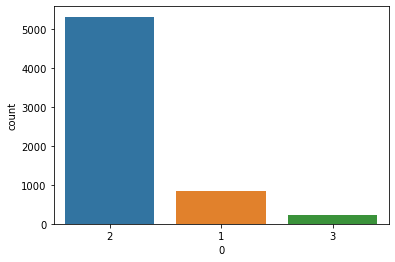

In [8]:
sns.countplot(cell_inds[0].apply(lambda x: x.split("-")[-1]))

## Filter for the flt3l genes 
Uses peak_annotations

In [9]:
flt3l_genes_upper = [x.upper() for x in flt3l_genes]
flt3l_anno = peak_annotations[peak_annotations["gene"].isin(flt3l_genes_upper)].set_index("Peak", drop=True).copy()
print(flt3l_anno.shape)
flt3l_anno

(64, 4)


,peak,gene,distance,peak_type
Peak,,,,
40846,chr4_143287660_143287679,GAB1,-49083,distal
40847,chr4_143289422_143289756,GAB1,-47006,distal
40848,chr4_143335598_143338115,GAB1,0,promoter
40849,chr4_143344808_143345187,GAB1,7922,distal
40850,chr4_143347691_143348822,GAB1,10805,distal
...,...,...,...,...
123636,chr17_75418563_75418766,GRB2,-12855,distal
123637,chr17_75426226_75426919,GRB2,-20518,distal
123638,chr17_75428800_75429211,GRB2,-23092,distal


In [10]:
peaks_sparse_mtx = peaks_sparse_mtx.loc[peaks_sparse_mtx["Peak"].isin(flt3l_anno.index)]
peaks_sparse_mtx["gene"] = peaks_sparse_mtx["Peak"].map(peak_annotations["gene"])
peaks_dense = peaks_sparse_mtx.pivot(index="Peak", columns="Cell",values="Count").fillna(0)

## The number of cells within a peak and number of peaks within a cell.

In [11]:
#flt3l_anno = peak_annotations[peak_annotations["gene"].isin(flt3l_genes)].copy()
#flt3l_inds = peak_annotations.index
flt3l_anno["ID"] = flt3l_anno.apply(lambda x: x["gene"]+"_"+x["peak_type"]+"_"+x["distance"],axis=1)
flt3l_peaks_dense = peaks_dense.loc[flt3l_anno.index].copy()
#flt3l_peaks_dense = flt3l_peaks_dense.rename(flt3l_anno.set_index("Peak").apply(lambda x: x["gene"]+"_"+x["peak_type"],axis=1), axis=0)
flt3l_peaks_dense

Cell,1,2,4,5,6,8,10,11,12,14,...,6364,6366,6368,6369,6370,6371,6372,6373,6376,6378
Peak,,,,,,,,,,,,,,,,,,,,,
40846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40848,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
40849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cluster based on flt3l genes 

## Cluster but align the conditions (dont cluster cols)

In [12]:
curr_CBs = CBs.loc[flt3l_peaks_dense.columns]
curr_CBs = curr_CBs.sort_values("Condition")
flt3l_peaks_dense = flt3l_peaks_dense.loc[:, curr_CBs.index]
flt3l_peaks_dense

Cell,1,3042,3038,3036,3027,3024,3020,3018,3015,3013,...,503,2064,1174,4132,2566,2059,4128,5541,5506,410
Peak,,,,,,,,,,,,,,,,,,,,,
40846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
40849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


clustering
cmap None


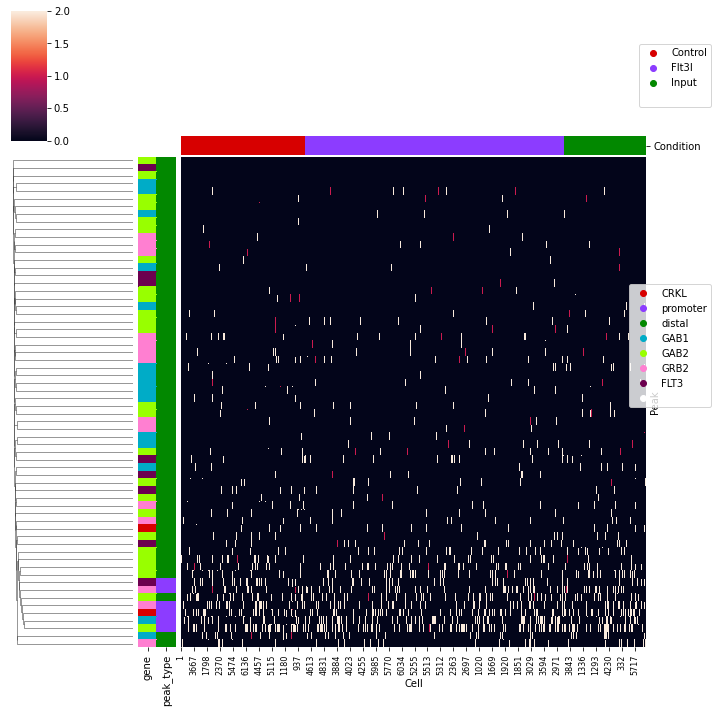

In [13]:
ch.plot_cluster(flt3l_peaks_dense.fillna(0), row_meta=flt3l_anno[["gene", "peak_type"]], 
                col_meta=curr_CBs.loc[flt3l_peaks_dense.columns][["Condition"]], to_row_clust=True, 
                metric='jaccard', to_legend=True, white_name=None, row_names=False, to_col_clust=False, 
               vmax=2)

clustering
cmap None


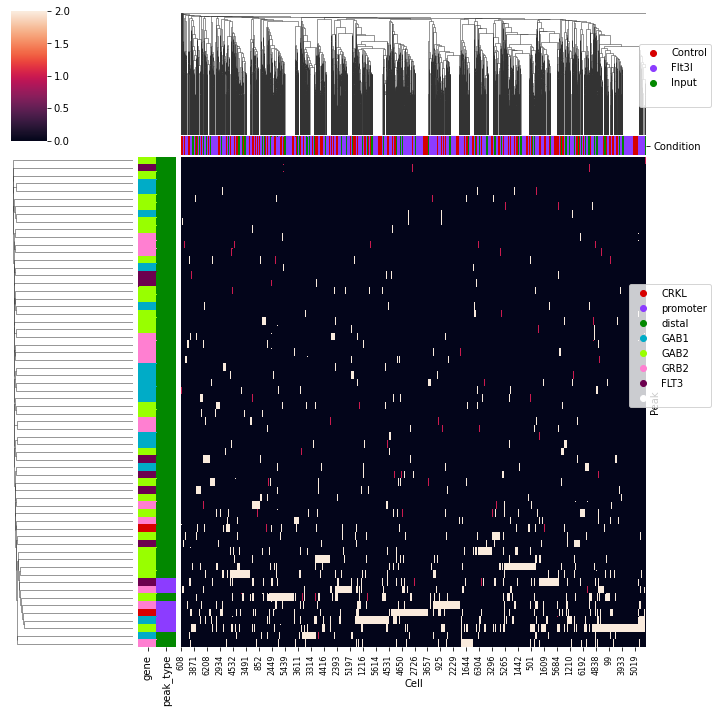

In [14]:
ch.plot_cluster(flt3l_peaks_dense.fillna(0), row_meta=flt3l_anno[["gene", "peak_type"]], 
                col_meta=curr_CBs.loc[flt3l_peaks_dense.columns][["Condition"]], to_row_clust=True, 
                metric='jaccard', to_legend=True, white_name=None, row_names=False, to_col_clust=True, 
               vmax=2)

## Only promoters

In [15]:
flt3l_proms = flt3l_anno[flt3l_anno["peak_type"] == "promoter"]
flt3l_proms

,peak,gene,distance,peak_type,ID
Peak,,,,,
40848,chr4_143335598_143338115,GAB1,0,promoter,GAB1_promoter_0
90475,chr11_78416153_78421298,GAB2,0,promoter,GAB2_promoter_0
100707,chr13_28099737_28102319,FLT3,0,promoter,FLT3_promoter_0
123632,chr17_75393556_75394460,GRB2,0,promoter,GRB2_promoter_0
123633,chr17_75404107_75407110,GRB2,0,promoter,GRB2_promoter_0
139250,chr22_20916683_20918278,CRKL,0,promoter,CRKL_promoter_0


clustering
cmap None


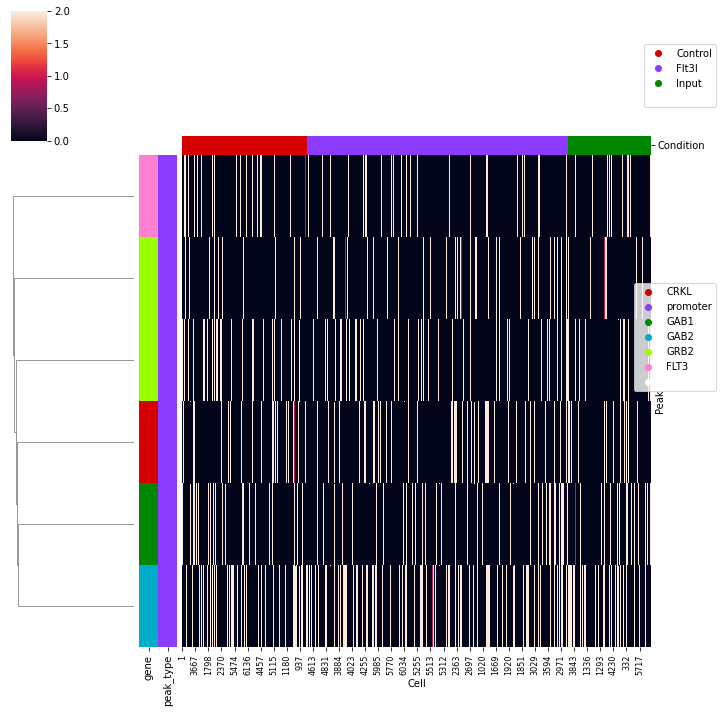

In [16]:
prom_flt3l_peaks_dense = flt3l_peaks_dense.loc[flt3l_proms.index]
ch.plot_cluster(prom_flt3l_peaks_dense, row_meta=flt3l_proms[["gene", "peak_type"]], 
                col_meta=curr_CBs.loc[prom_flt3l_peaks_dense.columns][["Condition"]], to_row_clust=True, 
                metric='jaccard', to_legend=True, white_name=None, row_names=False, to_col_clust=False, 
                vmax=2)

clustering
cmap None


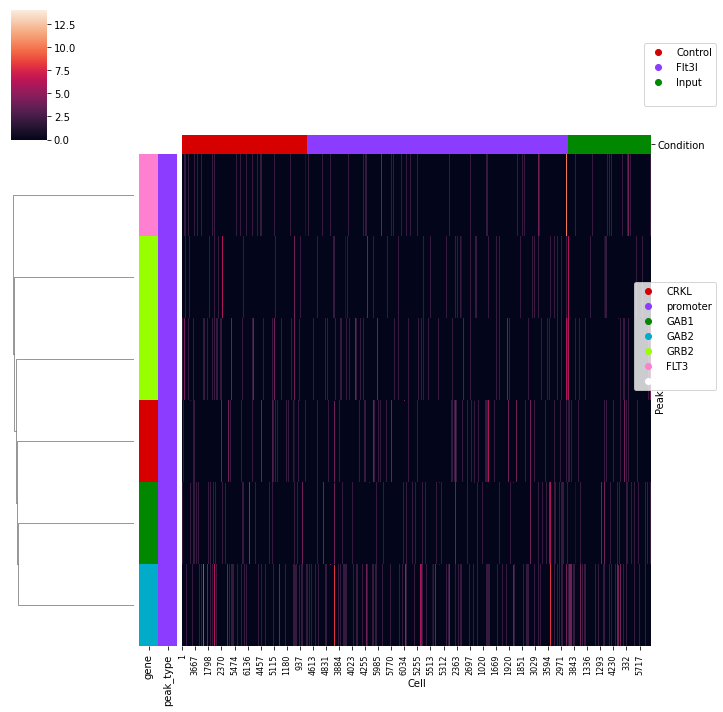

In [17]:
prom_flt3l_peaks_dense = flt3l_peaks_dense.loc[flt3l_proms.index]
ch.plot_cluster(prom_flt3l_peaks_dense, row_meta=flt3l_proms[["gene", "peak_type"]], 
                col_meta=curr_CBs.loc[prom_flt3l_peaks_dense.columns][["Condition"]], to_row_clust=True, 
                metric='jaccard', to_legend=True, white_name=None, row_names=False, to_col_clust=False)

clustering
cmap None


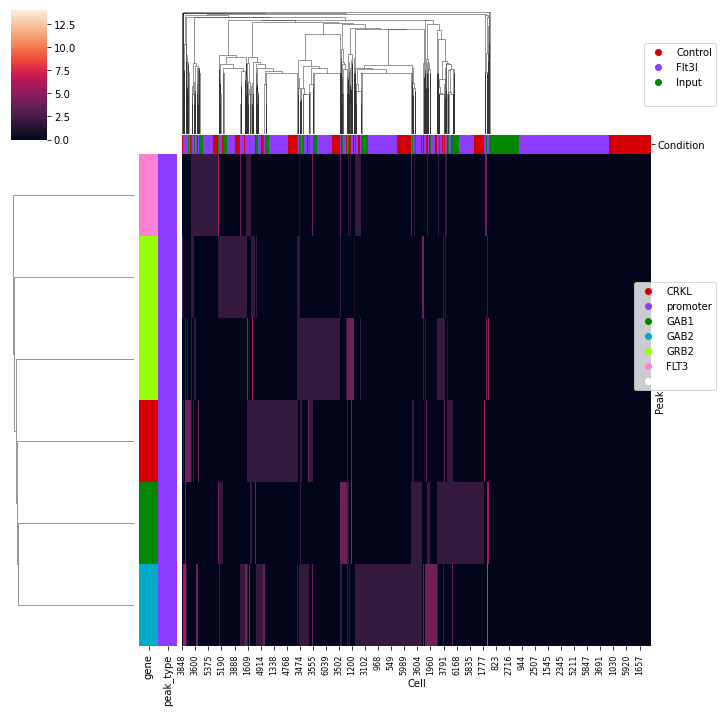

In [18]:
prom_flt3l_peaks_dense = flt3l_peaks_dense.loc[flt3l_proms.index]
ch.plot_cluster(prom_flt3l_peaks_dense, row_meta=flt3l_proms[["gene", "peak_type"]], 
                col_meta=curr_CBs.loc[prom_flt3l_peaks_dense.columns][["Condition"]], to_row_clust=True, 
                metric='jaccard', to_legend=True, white_name=None, row_names=False, to_col_clust=True)

## Countplots for each gene and peak type

/data/isshamie/software/anaconda3/envs/mito_trace/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='gene', ylabel='count'>

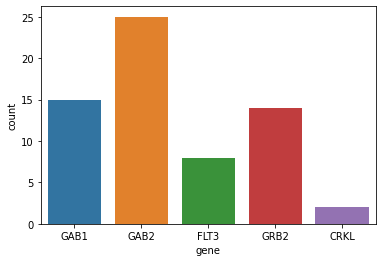

In [19]:
sns.countplot(flt3l_anno["gene"])

/data/isshamie/software/anaconda3/envs/mito_trace/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='peak_type', ylabel='count'>

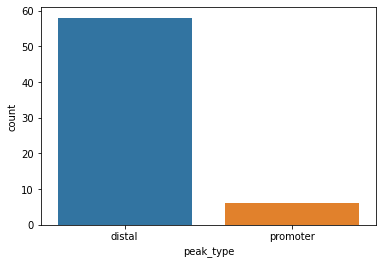

In [20]:
sns.countplot(flt3l_anno["peak_type"])